<a href="https://colab.research.google.com/github/ebudd45/HodoMap/blob/main/supermesoanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This cell only needs to be run once every time you reconnect to the server.
# After running this cell once, run the cell below this one (after modifying the
# inputs to suite your needs) as many times as you want to generate images.

# Install non-default libraries
!pip install cartopy
!pip install siphon
!pip install netCDF4

# Import libraries
import time
from datetime import datetime,timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from xarray import open_dataset
from xarray.backends import NetCDF4DataStore
from siphon.catalog import TDSCatalog
from netCDF4 import Dataset
import os
from scipy.interpolate import RectBivariateSpline
from urllib.request import urlretrieve
from matplotlib.colors import LinearSegmentedColormap

# You will likely see a bunch of runtime warnings pop up as the code is
# executing; don't worry about them, the code is working as intended.


Visible Imagery Chosen
(GOES-East ABI Channel 2, 0.64 μm Wavelength)

Time to download data from THREDDS: 10.919533491134644 seconds



<ipython-input-3-fdce82403431>:103: RuntimeWarning: divide by zero encountered in scalar divide
  MSE0hat[i]=(1/z[i])*np.sum(MSE0[0:i]*dz[0:i])
<ipython-input-3-fdce82403431>:103: RuntimeWarning: invalid value encountered in scalar multiply
  MSE0hat[i]=(1/z[i])*np.sum(MSE0[0:i]*dz[0:i])
<ipython-input-3-fdce82403431>:44: RuntimeWarning: invalid value encountered in sqrt
  r_s=(-b-(b**2-4*a*c)**0.5)/(2*a)


^
This is expected behavior; the code is working as intended

Time to retrieve and perform calculations on variables: 21.775317192077637 seconds

Time to generate plot: 25.64708423614502 seconds

Total script runtime: 58.34227275848389 seconds


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


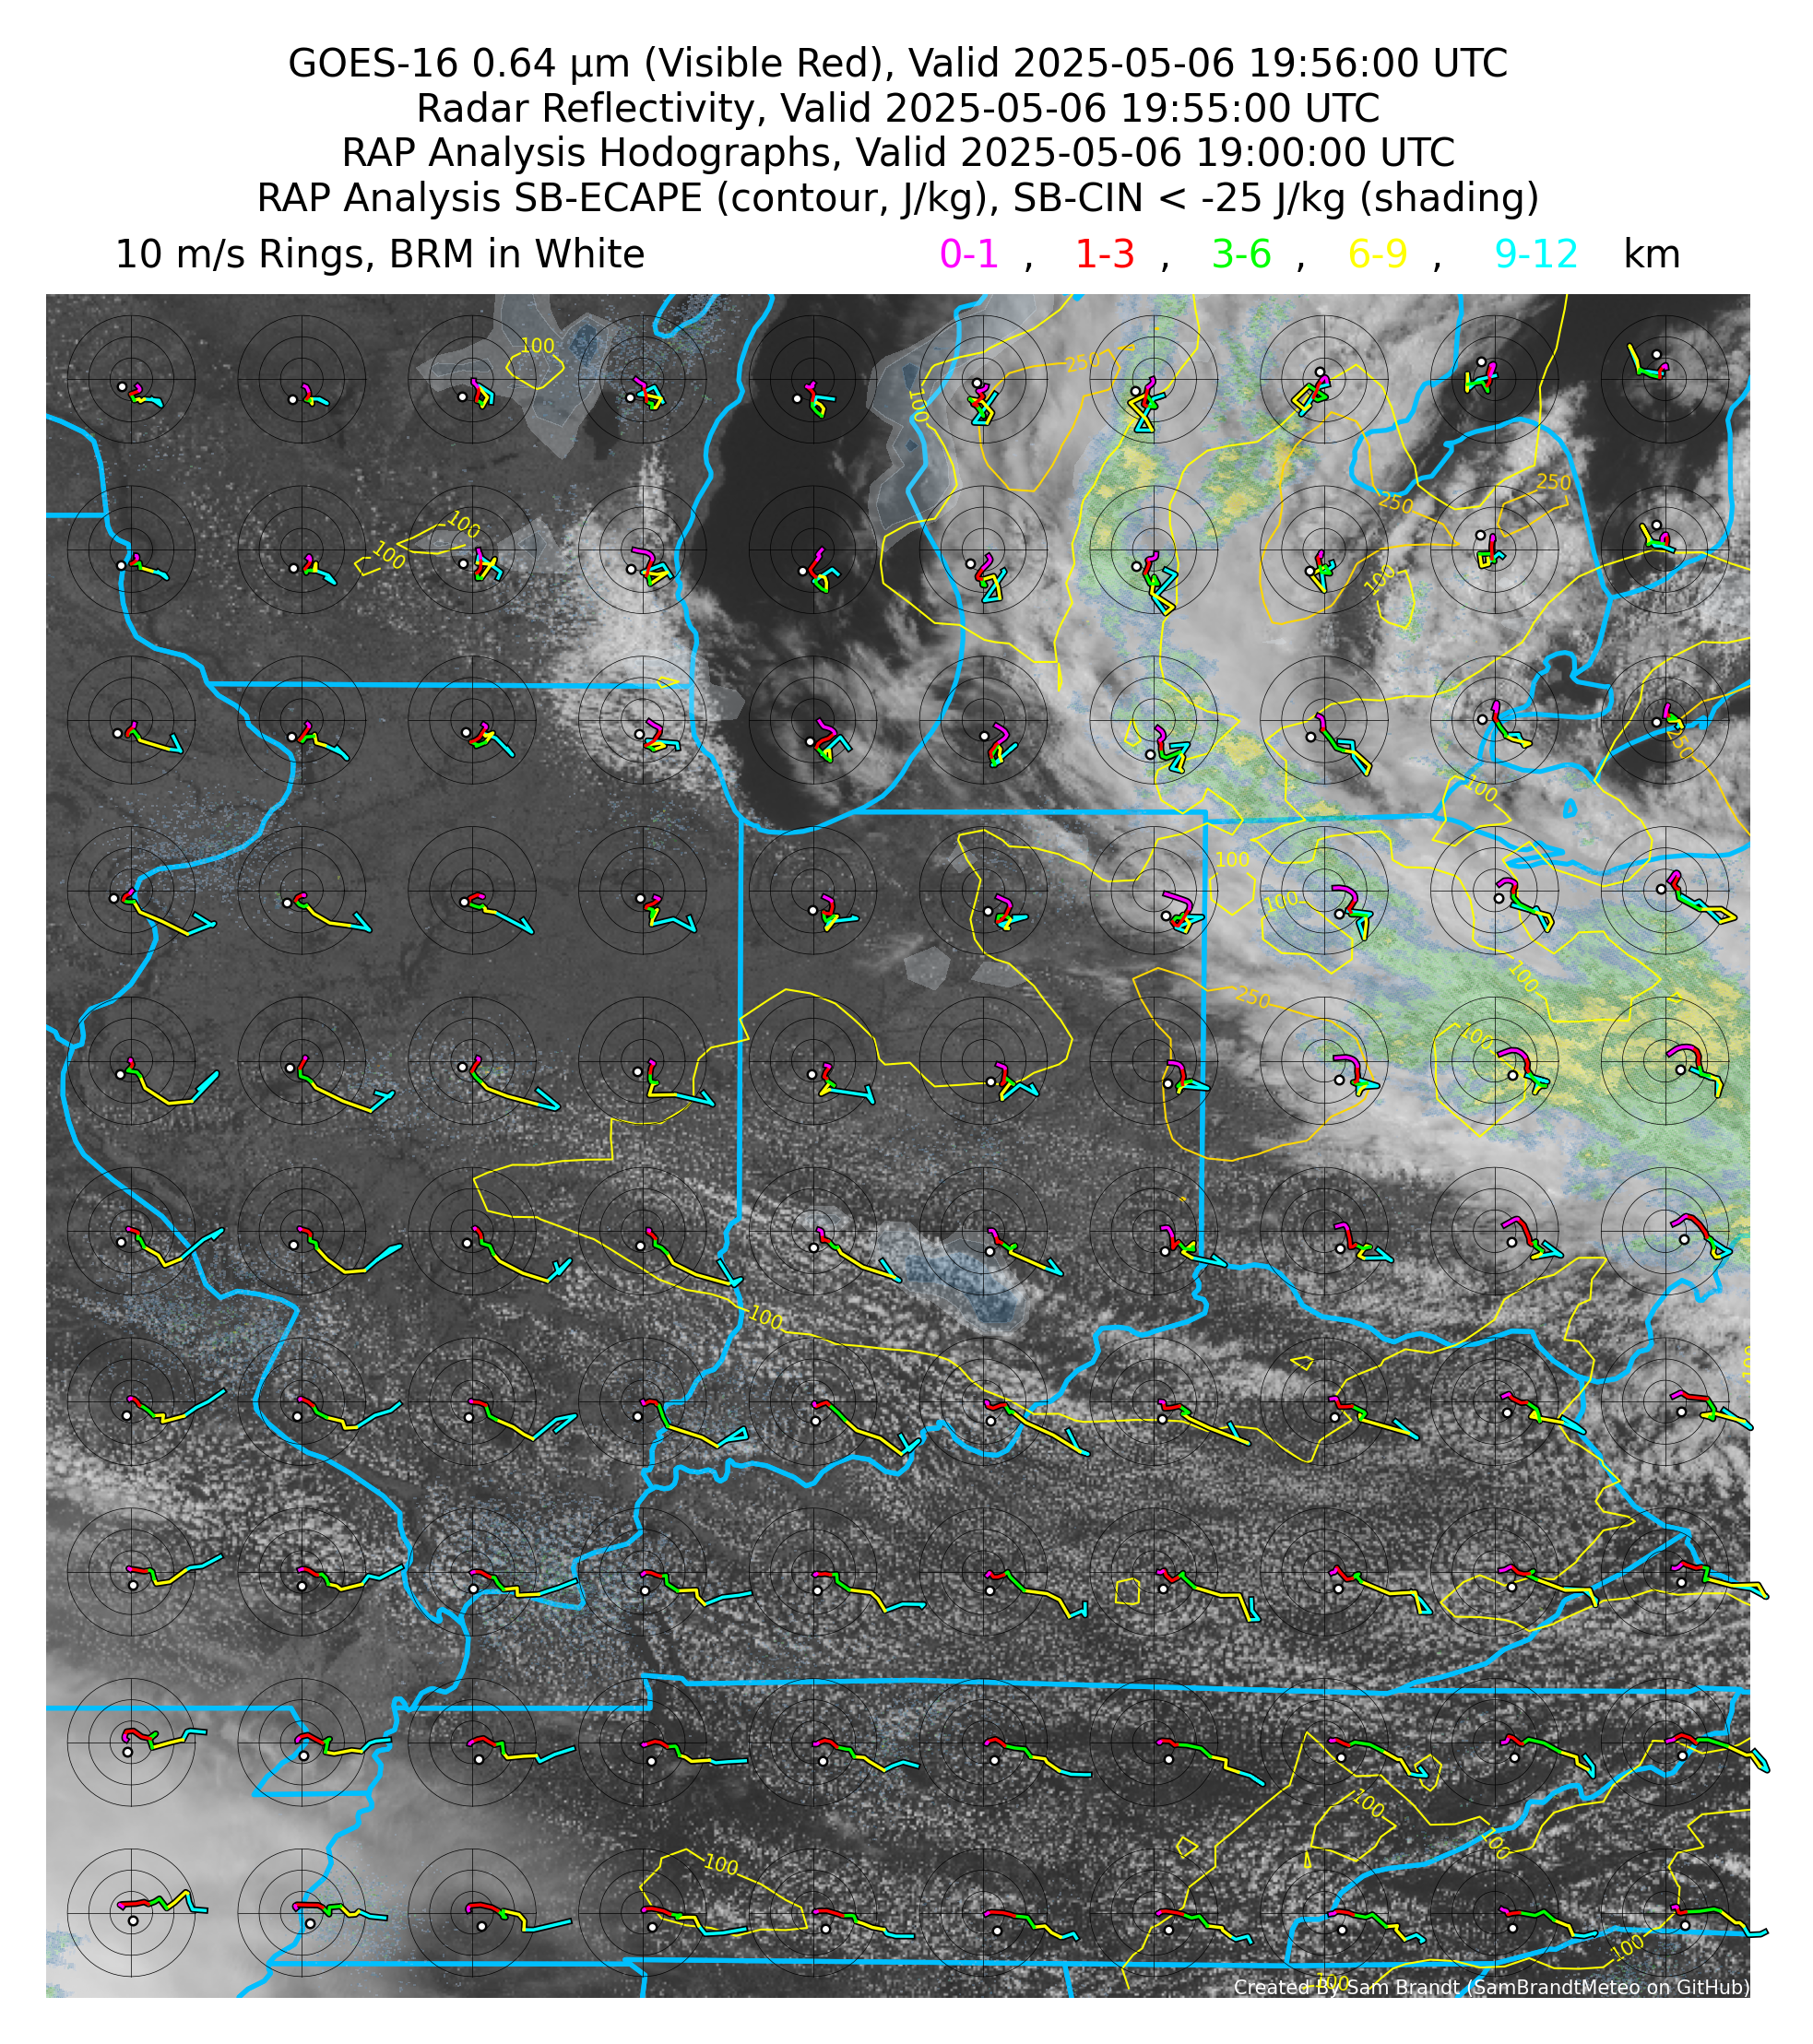

In [3]:
# INPUTS #

central_lat=39.8 # Specify the latitude of the map's center (in degrees).
central_lon=-86.6 # SPecify the longitude of the map's center (in degrees).
extent=5 # Specify how far from the central coordinates the map will go in each cardinal direction (in degrees).

Satellite='vis' # Choose your satellite imagery type (options are 'vis' for visible imagery and 'ir' for infrared imagery).

storm_motion='right' # Choose a storm motion to calculate ECAPE with; options are 'right', 'left', and 'mean', corresponding to Bunkers right, Bunkers left, and 0-6 km mean wind storm motion.

# PHYSICAL CONSTANTS #

g=9.81 # Acceleration due to gravity (m s^-1)
Rd=287.04 # Dry air gas constant (J kg^-1 K^-1)
Rv=461.5 # Water vapor gas constant (J kg^-1 K^-1)
cpd=1005 # Specific heat of dry air at constant pressure (J kg^-1 K^-1)
cpv=1870 # Specific heat of water vapor at constant pressure (J kg^-1 K^-1)
cl=4190 # Specific heat of liquid water (J kg^-1 K^-1)
LvRef=2501000 # Enthalpy of vaporization of water at triple point temperature (J kg^-1 K^-1)
pref=611.2 # Equilibrium vapor pressure of water at triple point temperature (Pa)
Tref=273.15 # Triple point temperature (K)
Pr=1/3 # Turbulent Prandtl number
k=0.42 # Von-Karman constant
Lmix=120 # Mixing length (m)
alpha=0.8
sigma=1.1

# FUNCTIONS #

def calc_latlon(data):
    # The math for this function was taken from https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x_1d = np.array(data['x'])*10**-6
    y_1d = np.array(data['y'])*10**-6
    x,y = np.meshgrid(x_1d,y_1d)
    goes_imager_projection=data.variables['fixedgrid_projection']
    r_eq=goes_imager_projection.semi_major_axis
    r_pol=goes_imager_projection.semi_minor_axis
    l_0=goes_imager_projection.longitude_of_projection_origin*(np.pi/180)
    h_sat=goes_imager_projection.perspective_point_height
    H=r_eq+h_sat
    a=np.sin(x)**2+(np.cos(x)**2*(np.cos(y)**2+(r_eq/r_pol)**2*np.sin(y)**2))
    b=-2*H*np.cos(x)*np.cos(y)
    c=H**2-r_eq**2
    r_s=(-b-(b**2-4*a*c)**0.5)/(2*a)
    print('^\nThis is expected behavior; the code is working as intended')
    s_x=r_s*np.cos(x)*np.cos(y)
    s_y=-r_s*np.sin(x)
    s_z=r_s*np.cos(x)*np.sin(y)
    lat=np.arctan((r_eq/r_pol)**2*(s_z/np.sqrt((H-s_x)**2+s_y**2)))*(180/np.pi)
    lon=(l_0-np.arctan(s_y/(H-s_x)))*(180/np.pi)
    return lon,lat,x_1d*h_sat,y_1d*h_sat

def bunkers(u,v,z,mover):
    # Calculates storm motions according to Bunkers et al. 2000 (https://doi.org/10.1175/1520-0434(2000)015<0061:PSMUAN>2.0.CO;2)
    prop=7.5
    upper=6000
    mwu=layer_mean(u[z<=upper], z[z<=upper], upper)
    mwv=layer_mean(v[z<=upper], z[z<=upper], upper)
    if mover=='mean':
        return mwu,mwv
    else:
        ulow=np.mean(u[z<=500])
        uupp=np.mean(u[np.logical_and(z>=upper-500,z<=upper)])
        vlow=np.mean(v[z<=500])
        vupp=np.mean(v[np.logical_and(z>=upper-500,z<=upper)])
        deltau=uupp-ulow
        deltav=vupp-vlow
        unitu=deltau/np.sqrt(deltau**2+deltav**2)
        unitv=deltav/np.sqrt(deltau**2+deltav**2)
        if mover=='right':
            rmu=mwu+prop*unitv
            rmv=mwv-prop*unitu
            return rmu,rmv
        elif mover=='left':
            lmu=mwu-prop*unitv
            lmv=mwv+prop*unitu
            return lmu,lmv

def Lv(T):
    # Calcuates enthalpy of vaporization as a function of temperature
    Tref=273.15
    Lv=LvRef+(T-Tref)*(cpv-cl)
    return Lv

def qv_eq(T,p):
    # Calcuates equilibruim water vapor mass fraction as a function of temperature and pressure
    qv_eq=(Rd/Rv)*(pref/p)*np.exp(-(Lv(T)/Rv)*(1/T-1/Tref))
    return qv_eq

def MSE(T,qv,z):
    # Calculates moist static energy as a function of temperature, water vapor mass fraction, and geometric height
    thermal=((1-qv)*cpd+qv*cl)*T
    latent=(LvRef+(T-Tref)*(cpv-cl))*qv
    potential=g*z
    return thermal+latent+potential

def NCAPE(T0,qv0,z,p,LFC,EL):
    # Calculates NCAPE according to Peters et al. 2023 (https://doi.org/10.1175/JAS-D-23-0003.1)
    MSE0=MSE(T0,qv0,z)
    MSE0hat=np.zeros(len(z))
    dz=z[1:]-z[0:-1]
    for i in range(1,len(z)):
        MSE0hat[i]=(1/z[i])*np.sum(MSE0[0:i]*dz[0:i])
    MSE0hat[0]=MSE0hat[1]
    MSE0star=MSE(T0,qv_eq(T0,p),z)
    integrand=(MSE0hat-MSE0star)/T0
    dz=np.insert(dz,0,dz[0])
    N=-(g/cpd)*np.sum(integrand[np.logical_and(z>=LFC,z<=EL)]*dz[np.logical_and(z>=LFC,z<=EL)])
    return N

def psi_calc(EL):
    # Calculates psi according to Peters et al. 2023 (https://doi.org/10.1175/JAS-D-23-0003.1)
    return ((k**2)*(alpha**2)*(np.pi**2)*Lmix)/(4*Pr*(sigma**2)*EL)

def layer_mean(var,z,top):
    # Calculates the average of a quantity over a 0-top meter layer with arbitrary vertical spacing
    dz=z[1:]-z[0:-1]
    dz=np.insert(dz,-1,dz[-1])
    dz=dz[z<=top][0:-1]
    var=var[z<=top][0:-1]
    weights=dz/np.sum(dz)
    return np.sum(var*weights)

def E_calc(V,N,psi):
    # Calculates E_A according to Peters et al. 2023 (https://doi.org/10.1175/JAS-D-23-0003.1)
    return V**2+(-1-psi-(psi*N)/V**2+np.sqrt((1+psi+(psi*N)/V**2)**2+(4*psi*(1-psi*N))/V**2))/((2*psi)/V**2)

def Entraining_CAPE(z,p,T0,qv0,u,v,LCL,EL,CAPE,storm_motion='right'):
    # Calculates E_A according to Peters et al. 2023 (https://doi.org/10.1175/JAS-D-23-0003.1)
    # E_A * CAPE = ECAPE
    uSM,vSM=bunkers(u,v,z,storm_motion)
    uSR=u-uSM
    vSR=v-vSM
    SR=layer_mean(np.sqrt(uSR**2+vSR**2),z,1000)
    if CAPE==0:
        return 0
    elif CAPE>0:
        N=NCAPE(T0,qv0,z,p,LCL,EL)/CAPE
        psi=psi_calc(EL)
        V=SR/np.sqrt(2*CAPE)
        E=E_calc(V, N, psi)
        return E

# DATA RETRIEVAL #

time0=time.time()

# Calculate map extent
north=central_lat+extent
south=central_lat-extent
east=central_lon+extent
west=central_lon-extent

# Determine whether to use visible or IR imagery based on user input

# Visible
if Satellite=='vis':
    channel='Channel02'
    wavelength='0.64'
    sat_type='Visible Red'
    lowerclip=0
    upperclip=1
    gamma=2
    cmap_sat='gray'
    print('\nVisible Imagery Chosen'
          '\n(GOES-East ABI Channel 2, 0.64 μm Wavelength)')

# Infrared
elif Satellite=='ir':
    channel='Channel07'
    wavelength='3.9'
    sat_type='IR Shortwave'
    lowerclip=273.15-80
    upperclip=273.15+50
    gamma=1
    cmap_sat='gray_r'
    print('\nInfrared Imagery Chosen'
          '\n(GOES-East ABI Channel 7, 3.9 μm Wavelength)')

time1=time.time()

# Download GOES data
sat_url='https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/'+channel+'/current/catalog.xml'
sat_cat=TDSCatalog(sat_url)
sat_ds = sat_cat.datasets[-1]
sat_url=sat_ds.access_urls['HTTPServer']
tempfile=urlretrieve(sat_url,'temp_sat.nc')
sat_data=Dataset('temp_sat.nc')
os.remove('temp_sat.nc')
sat_valid_datetime=datetime(int(sat_url[-17:-13]),1,1,int(sat_url[-10:-8]),int(sat_url[-8:-6]))+timedelta(int(sat_url[-13:-10])-1)
sat_valid=str(sat_valid_datetime)

# Download radar reflectivity data
if sat_valid_datetime.minute%5==0:
    radar_valid_datetime=sat_valid_datetime
elif sat_valid_datetime.minute%5!=0:
    radar_valid_datetime=sat_valid_datetime-timedelta(minutes=sat_valid_datetime.minute%5)
radar_url='https://thredds.ucar.edu/thredds/catalog/nexrad/composite/gini/dhr/1km/'+str(radar_valid_datetime.year)+str(radar_valid_datetime.month).zfill(2)+str(radar_valid_datetime.day).zfill(2)+'/catalog.xml'
best_radar=TDSCatalog(radar_url)
radar_ds=best_radar.datasets
ncss1=radar_ds[0].subset()
query = ncss1.query()
query.lonlat_box(north=north+1,south=south-1,east=east+1,west=west-1)
query.add_lonlat(value=True)
query.accept('netcdf4')
query.variables('Reflectivity')
radar_data=ncss1.get_data(query)
radar_data=open_dataset(NetCDF4DataStore(radar_data),decode_times=False)
radar_lat=np.array(radar_data['lat'])
radar_lon=np.array(radar_data['lon'])
dBz=np.array(radar_data['Reflectivity'])[0,:,:]

# Create a custom colormap for radar data
radar_cmap=LinearSegmentedColormap.from_list('custom_cmap',['lightsteelblue','steelblue','lightgreen','forestgreen',[255/255,255/255,77/255],[230/255,230/255,0],[255/255,195/255,77/255],[230/255,153/255,0],[255/255,77/255,77/255],[230/255,0,0],[255/255,204/255,238/255],[255/255,25/255,140/255],[212/255,0,255/255],[85/255,0,128/255]],N=256)
radar_valid=str(radar_valid_datetime.year)+'-'+str(radar_valid_datetime.month).zfill(2)+'-'+str(radar_valid_datetime.day).zfill(2)+' '+str(radar_valid_datetime.hour).zfill(2)+':'+str(radar_valid_datetime.minute).zfill(2)+':00 UTC'
dBz=np.ma.masked_array(dBz,dBz<10)

# Donwload RAP data
rap_url='https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_13km/latest.xml'
best_rap=TDSCatalog(rap_url)
rap_ds=best_rap.datasets
ncss=rap_ds[0].subset()
query = ncss.query()
query.lonlat_box(north=north,south=south,east=east,west=west).time_range(sat_valid_datetime,sat_valid_datetime)
query.add_lonlat(value=True)
query.accept('netcdf4')
query.variables('Geopotential_height_isobaric','v-component_of_wind_height_above_ground','u-component_of_wind_height_above_ground','v-component_of_wind_isobaric','u-component_of_wind_isobaric','Pressure_surface','U-Component_Storm_Motion_height_above_ground_layer','V-Component_Storm_Motion_height_above_ground_layer','Convective_available_potential_energy_surface','Convective_inhibition_surface','Temperature_isobaric','Relative_humidity_isobaric','Temperature_height_above_ground','Relative_humidity_height_above_ground','Geopotential_height_cloud_base','Geopotential_height_equilibrium')
rap_data=ncss.get_data(query)
rap_data=open_dataset(NetCDF4DataStore(rap_data))
rap_valid=ncss.metadata.time_span['begin'][0:10]+' '+str(sat_valid_datetime.hour).zfill(2)+':00:00'
hodo_lon=np.arange(west+0.1*extent,east,0.2*extent)
hodo_lat=np.arange(south+0.1*extent,north,0.2*extent)

# Elapsed time check
time2=time.time()
print('\nTime to download data from THREDDS:',time2-time1,'seconds\n')

# ECAPE calculation
cape=np.array(rap_data['Convective_available_potential_energy_surface'][0,:,:])
LCL=np.array(rap_data['Geopotential_height_cloud_base'][0,:,:])
EL=np.array(rap_data['Geopotential_height_equilibrium'][0,:,:])
cin=np.array(rap_data['Convective_inhibition_surface'][0,:,:])
lon=np.array(rap_data['lon'][0,:])
lat=np.array(rap_data['lat'][:,0])
p=np.arange(100,1025,25)*100
Tsfc=np.array(rap_data['Temperature_height_above_ground'][0,0,:,:])
RHsfc=np.array(rap_data['Relative_humidity_height_above_ground'][0,0,:,:])/100
psfc=np.array(rap_data['Pressure_surface'][0,:,:])
Tiso=np.array(rap_data['Temperature_isobaric'][0,:,:,:])
RHiso=np.array(rap_data['Relative_humidity_isobaric'][0,:,:,:])/100
qvsfc=qv_eq(Tsfc,psfc)*RHsfc
qviso=qv_eq(Tiso,np.repeat(np.repeat(p[:,np.newaxis],len(Tsfc[:,0]),axis=1)[:,:,np.newaxis],len(Tsfc[0,:]),axis=2))*RHiso
usfc=np.array(rap_data['u-component_of_wind_height_above_ground'][0,0,:,:])
vsfc=np.array(rap_data['v-component_of_wind_height_above_ground'][0,0,:,:])
uiso=np.array(rap_data['u-component_of_wind_isobaric'][0,:,:,:])
viso=np.array(rap_data['v-component_of_wind_isobaric'][0,:,:,:])
gpht=np.array(rap_data['Geopotential_height_isobaric'][0,:,:,:])
E=np.zeros(np.shape(Tsfc))
for i in range(0,len(Tsfc[:,0])):
    for j in range(0,len(Tsfc[0,:])):
        gpht_sfc=np.interp([psfc[i,j]],p,gpht[:,i,j])[0]
        z=gpht[:,i,j]-gpht_sfc
        T0=Tiso[z>=0,i,j]
        qv0=qviso[z>=0,i,j]
        u=uiso[z>=0,i,j]
        v=viso[z>=0,i,j]
        pp=p[z>=0]
        z=z[z>=0]
        T0=np.flip(np.append(T0,[Tsfc[i,j]]))
        qv0=np.flip(np.append(qv0,[qvsfc[i,j]]))
        u=np.flip(np.append(u,[usfc[i,j]]))
        v=np.flip(np.append(v,[vsfc[i,j]]))
        pp=np.flip(np.append(pp,[psfc[i,j]]))
        z=np.flip(np.append(z,[0]))
        E[i,j]=Entraining_CAPE(z,pp,T0,qv0,u,v,LCL[i,j]-gpht_sfc,EL[i,j]-gpht_sfc,cape[i,j],storm_motion='right')

# Retrieve, interpolate RAP variables for hodographs
psfc=RectBivariateSpline(lon,lat,np.array(rap_data['Pressure_surface'][0,:,:]).T)(hodo_lon,hodo_lat)
u_sfc=RectBivariateSpline(lon,lat,np.array(rap_data['u-component_of_wind_height_above_ground'][0,0,:,:]).T)(hodo_lon,hodo_lat)
v_sfc=RectBivariateSpline(lon,lat,np.array(rap_data['v-component_of_wind_height_above_ground'][0,0,:,:]).T)(hodo_lon,hodo_lat)
u_sm=RectBivariateSpline(lon,lat,np.array(rap_data['U-Component_Storm_Motion_height_above_ground_layer'][0,0,:,:]).T)(hodo_lon,hodo_lat)
v_sm=RectBivariateSpline(lon,lat,np.array(rap_data['V-Component_Storm_Motion_height_above_ground_layer'][0,0,:,:]).T)(hodo_lon,hodo_lat)
gpht=[]
u_iso=[]
v_iso=[]
for i in range(0,37):
    gpht.append(RectBivariateSpline(lon,lat,np.array(rap_data['Geopotential_height_isobaric'][0,i,:,:]).T)(hodo_lon,hodo_lat))
    u_iso.append(RectBivariateSpline(lon,lat,np.array(rap_data['u-component_of_wind_isobaric'][0,i,:,:]).T)(hodo_lon,hodo_lat))
    v_iso.append(RectBivariateSpline(lon,lat,np.array(rap_data['v-component_of_wind_isobaric'][0,i,:,:]).T)(hodo_lon,hodo_lat))
gpht=np.array(gpht)
u_iso=np.array(u_iso)
v_iso=np.array(v_iso)

# Get surface height for hodographs
gpht_sfc=np.zeros((10,10))
for i in range(0,10):
    for j in range(0,10):
        gpht_sfc[i,j]=np.interp([psfc[i,j]],p,gpht[:,i,j])[0]
        gpht[:,i,j]=gpht[:,i,j]-gpht_sfc[i,j]

# PLOTTING #

# Gamma correction
sat=np.array(sat_data['Sectorized_CMI'])**(1/gamma)
sat=np.clip(sat,lowerclip,upperclip)

# Mask values not in the specified domain
# Speeds up plotting for later, especially with the higher-resolution visible imagery
sat_lon,sat_lat,x_sat,y_sat=calc_latlon(sat_data)
sat_bool=np.logical_and(np.logical_and(sat_lat>=south-extent/2,sat_lat<=north+extent/2),np.logical_and(sat_lon>=west-extent/2,sat_lon<=east+extent/2))
sat=np.ma.masked_where(sat_bool==False,sat)

# Time check #2
time3=time.time()
print('\nTime to retrieve and perform calculations on variables:',time3-time2,'seconds')

# Create a tuple representing the bounds of the satellite data to be plotted
imextent_sat=(x_sat.min(),x_sat.max(),y_sat.min(),y_sat.max())

# Create a geostationary axis
globe_sat=ccrs.Globe(semimajor_axis=sat_data['fixedgrid_projection'].semi_major_axis,semiminor_axis=sat_data['fixedgrid_projection'].semi_minor_axis)
crs_sat=ccrs.Geostationary(central_longitude=sat_data['fixedgrid_projection'].longitude_of_projection_origin,globe=globe_sat)

# Create figure
fig=plt.figure(dpi=500)

# Create cartopy axis
ax=plt.axes(projection=ccrs.PlateCarree())

# Make axis invisible
ax.axis('off')

# Set axis bounds
ax.set_extent([west,east,south,north])

# Add geographic features
#ax.coastlines(linewidth=0.75,edgecolor='deepskyblue',zorder=1)
ax.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='deepskyblue',linewidth=0.75,zorder=1)

# Display satellite imagery
im_sat=ax.imshow(sat,origin='upper',extent=imextent_sat,interpolation=None,transform=crs_sat,cmap=cmap_sat,vmin=lowerclip,vmax=upperclip,zorder=0)

# Create meshgrid for contour plotting
lon,lat=np.meshgrid(lon,lat)

# Plot ECAPE contours
cc=ax.contour(lon,lat,E*cape,[100,250,500,1000,1500,2000,2500,3000,4000,5000],colors=['yellow','gold','orange','orangered','red','crimson','deeppink','magenta','mediumorchid','blueviolet'],linewidths=0.3)
ax.clabel(cc, cc.levels, inline=True, fontsize=3)

# Plot CIN shading
ht=ax.contourf(lon,lat,cin,[-200,-100,-50,-25],cmap='Blues_r',alpha=0.25,extend='min')

# Plot Radar
ax.pcolormesh(radar_lon+0.05,radar_lat+0.05,dBz,vmin=10,vmax=80,cmap=radar_cmap,alpha=0.33)
# The 0.05 deg shifts are to offset parallax between the low-level radar imagery and upper level cloud features on satellite

# Create angles for ring plotting
angles=np.arange(0,2*np.pi+np.pi/32,np.pi/32)

# Loop through every hodograph axis
for i in range(0,10):
    for j in range(0,10):

        # Create hodograph axis
        axin = ax.inset_axes((i/10,j/10,0.1,0.1))

        # Make the axis invisible
        axin.axis('off')

        # Set axis limits (m/s)
        axin.set_xlim(-40,40)
        axin.set_ylim(-40,40)

        # Plot axes and rings
        axin.plot(10*np.cos(angles),10*np.sin(angles),color='black',lw=0.1,zorder=0)
        axin.plot(20*np.cos(angles),20*np.sin(angles),color='black',lw=0.1,zorder=0)
        axin.plot(30*np.cos(angles),30*np.sin(angles),color='black',lw=0.1,zorder=0)
        axin.plot([0,0],[-30,30],color='black',lw=0.1,zorder=0)
        axin.plot([-30,30],[0,0],color='black',lw=0.1,zorder=0)

        # Create the interpolated u,v,z arrays for plotting
        hgts=np.flip(gpht[:,i,j][gpht[:,i,j]>=0])
        u_plot=np.flip(u_iso[:,i,j][gpht[:,i,j]>=0])
        v_plot=np.flip(v_iso[:,i,j][gpht[:,i,j]>=0])
        hgts=np.insert(hgts,0,0)
        u_plot=np.insert(u_plot,0,u_sfc[i,j])
        v_plot=np.insert(v_plot,0,v_sfc[i,j])
        hgt_plot=np.concatenate((np.arange(0,1000,100),np.arange(1000,3000,500),np.arange(3000,13000,1000)),axis=0)
        u_plot=np.interp(hgt_plot,hgts,u_plot)
        v_plot=np.interp(hgt_plot,hgts,v_plot)

        # Plot the hodograph
        axin.plot(u_plot[hgt_plot<=12000],v_plot[hgt_plot<=12000],color='black',lw=1,clip_on=False,zorder=1)
        axin.plot(u_plot[np.logical_and(hgt_plot<=12000,hgt_plot>=9000)],v_plot[np.logical_and(hgt_plot<=12000,hgt_plot>=9000)],color='cyan',lw=0.5,clip_on=False,zorder=1)
        axin.plot(u_plot[np.logical_and(hgt_plot<=9000,hgt_plot>=6000)],v_plot[np.logical_and(hgt_plot<=9000,hgt_plot>=6000)],color='yellow',lw=0.5,clip_on=False,zorder=1)
        axin.plot(u_plot[np.logical_and(hgt_plot<=6000,hgt_plot>=3000)],v_plot[np.logical_and(hgt_plot<=6000,hgt_plot>=3000)],color='lime',lw=0.5,clip_on=False,zorder=1)
        axin.plot(u_plot[np.logical_and(hgt_plot<=3000,hgt_plot>=1000)],v_plot[np.logical_and(hgt_plot<=3000,hgt_plot>=1000)],color='red',lw=0.5,clip_on=False,zorder=1)
        axin.plot(u_plot[np.logical_and(hgt_plot<=1000,hgt_plot>=0)],v_plot[np.logical_and(hgt_plot<=1000,hgt_plot>=0)],color='magenta',lw=0.5,clip_on=False,zorder=1)

        # Plot the bunkers storm motion
        axin.scatter(u_sm[i,j],v_sm[i,j],s=3,c='black',linewidths=0,edgecolors=None,clip_on=False,zorder=2)
        axin.scatter(u_sm[i,j],v_sm[i,j],s=1,c='white',linewidths=0,edgecolors=None,clip_on=False,zorder=2)

# Title
ax.set_title('GOES-16 '+wavelength+' µm ('+sat_type+'), Valid '+sat_valid+' UTC\nRadar Reflectivity, Valid '+radar_valid+'\nRAP Analysis Hodographs, Valid '+rap_valid+' UTC\nRAP Analysis SB-ECAPE (contour, J/kg), SB-CIN < -25 J/kg (shading)\n',fontsize=6)
ax.text(east-2*extent*0.04,north+extent/15,'km',fontsize=6,color='black',ha='right',va='top')
ax.text(east-5*extent*0.04,north+extent/15,'9-12',fontsize=6,color='cyan',ha='right',va='top')
ax.text(east-9*extent*0.04,north+extent/15,',',fontsize=6,color='black',ha='right',va='top')
ax.text(east-10*extent*0.04,north+extent/15,'6-9',fontsize=6,color='yellow',ha='right',va='top')
ax.text(east-13*extent*0.04,north+extent/15,',',fontsize=6,color='black',ha='right',va='top')
ax.text(east-14*extent*0.04,north+extent/15,'3-6',fontsize=6,color='lime',ha='right',va='top')
ax.text(east-17*extent*0.04,north+extent/15,',',fontsize=6,color='black',ha='right',va='top')
ax.text(east-18*extent*0.04,north+extent/15,'1-3',fontsize=6,color='red',ha='right',va='top')
ax.text(east-21*extent*0.04,north+extent/15,',',fontsize=6,color='black',ha='right',va='top')
ax.text(east-22*extent*0.04,north+extent/15,'0-1',fontsize=6,color='magenta',ha='right',va='top')
ax.text(west+2*extent*0.04,north+extent/15,'10 m/s Rings, BRM in White',fontsize=6,color='black',ha='left',va='top')

# Signature
ax.text(east,south,'Created By Sam Brandt (SamBrandtMeteo on GitHub)',fontsize=3,color='white',ha='right',va='bottom')

# Time check #3
time4=time.time()
print('\nTime to generate plot:',time4-time3,'seconds')

# Total runtime check
print('\nTotal script runtime:',time4-time0,'seconds')